# Neural Networks with PyTorch

The goal of this notebook is to introduce the Multilayer Perceptron (the first so-called "deep" neural network) and nonlinear modeling. We'll quit doing all the gradients by hand. Instead, we'll use PyTorch.

We'll introduce classification and we'll observe a problem that a linear model can't solve. We'll see that the Multilayer Perceptron makes short work of it. Then we'll apply our Multilayer Perceptron to the Boston House Dataset regression problem.

## Introducing: The Multilayer Perceptron!

(Disclaimer: The transformation $T(x) = Ax+b$ is technically a nonlinear transformation. By certain definitions, it is an "affine transformation." We're going to call it linear. If for no other reason, we're doing that because PyTorch uses the word "linear" for a transformation of that form. Historically, linear modeling (in the true sense) probably came first, and then people added bias to it and still called it linear. At least, that's standard in lots of developments.)

Let's discuss the **multilayer perceptron** (MLP), a specific class of neural network that introduces nonlinearity.

The Multilayer perceptron is described as several **layers** of linear models, separated by a nonlinear **activation function.** Let's break that down.

Let's revisit our linear model and introduce some slightly suped-up notation.

Also, we're going to drop the $\vec{\cdot}$ notation. It should be easy enough to tell what's a vector and what's a scalar.

$$\hat{y} = \text{Net}(x) = \text{Net}(x, \theta)$$
where $\theta$ is a vector of all the parameters. By parameters, we mean individual weights $w_k$ and biases $b$.

Hereafter, we use the term **parameters** interchangeably with **weights**. This doesn't mean we're excluding biases. It's just a standard term.

We're going to hide the $\theta$ usually, but sometimes it's convenient to see the dependence on the weights.


So...
$$\text{Net}(x) = w_{0} x_{0} + w_1 x_1 + \dots w_K x_K + b$$
where $K$ is the number of features in $x$.

If we wanted to create a nonlinear model, one way would be by choosing a nonlinear function $f$ that maps real numbers to real numbers, and applying it to the output of the linear model. That is,
$$ \text{Net}_2(x) = f(w_0 x_0 + w_1 x_1 + \cdots + w_K x_K + b).$$

Then, to use gradient descent, finding the partial derivative of a weight with respect to the network output is as simple as applying the chain rule to 
$$f(\text{the original network}) = f'(\text{the original network}) \times \text{derivative of the original network}.$$

However, from a statistical lens, that imposes harsh restrictions on the distribution of $\hat{y}$. For example, if we chose a logistic (aka **sigmoid**) nonlinearity with range $[-1, 1]$, then our output distribution is bounded. That's undesiriable.

In reality, what we're going to do is map $x$ into an $H$-dimensional **feature space** using a linear transformation. Recall that $x$ has $K$ features. We're going to map $x$ linearly to a vector that has $H$ dimensions as follows:
$$
    z_0 = w_{0,0} x_0 + w_{1,0} x_1 + \cdots + x_{K,0} x_K + b_0 = \vec{w}_0 \cdot \vec{x} + b_0,
$$
$$
    z_1 = w_{0,1} x_0 + w_{1,1} x_1 + \cdots + x_{K,1} x_K + b_1 = \vec{w}_1 \cdot \vec{x} + b_1,
$$
$$
    \dots
$$
$$
    z_H = w_{0,H} x_0 + w_{1,H} x_1 + \cdots + x_{K,H} x_K + b_H = \vec{w}_H \cdot \vec{x} + b_H.
$$
In other words, we're mapping each of the $H$ derived features linearly.
In short,
$$ z = x W + b$$
where $z$ is an $H$-dimensional vector, $x$ is a $K$-dimensional vector, $W$ is a $(K,H)$-shaped matrix, and $b$ is an $H$-dimensional vector.

Note that we can express a linear network as a transformation where $H=1$.

Then, we're going to apply our activation function to each element of $z$ independently, aka **pointwise**.

Then, we'll apply a linear network where $H$ is the output dimension (for the Boston house dataset, that's $H=1$. But, for other problems where we want to predict multiple related functions, $H$ may be some other natural number).

So,
$$ \text{Net}(x) = [ f^{(0)} ( x W^{(0)} + b^{(0)} )] W^{(1)} + b^{(1)}.$$
where the superscript is the layer index.

## Universal Approximation Theorem

It turns out that with some modest restrictions the activation function $f^{(0)}$, we can prove that $\text{Net}(x)$ with one layer and an arbitrarily large $H$ could in theory approximate (almost) any function arbitrarily well. That's the "Universal Approximation Theorem."

You owe it to yourself to read the full mathy version (see the Unbounded width case): https://en.wikipedia.org/wiki/Universal_approximation_theorem (2 min)

The restrictions as presented are: The activation function is (1) nonconstant, (2) bounded (turns out that doesn't always matter), and (3) continuous. You'll never be able to make a nonconstant and bounded linear function, so "nonlinear" is a pretty good analog. And, the function you want to approximate is continuous and defined on a bounded domain (meaning, you can't extrapolate infinitely). Then, there exist weights such that your neural network is an arbitrarily good approximation of that function.

The catch is, it doesn't tell us how large of an $H$ and it doesn't tell us that gradient descent could ever find the right weights.

More info, if you're so inclined: https://towardsdatascience.com/can-neural-networks-really-learn-any-function-65e106617fc6 (15 min)

## XOR With PyTorch

As a simple example of the Universal Approximation Theorem at work, and of how **classification** (instead of regression) works, let's look at approximating the Exclusive-OR (XOR) function. "One or the other, but not both."

This is going to be very theoretical. We're not interested in generalization or data-science-y stuff. We just want to see if a linear model can learn to approximate the XOR function and if our new suped-up network can.

PyTorch is a production-quality software package that lets us build neural networks without caring about the calculus (yay!).

Required reading:
1. "What is PyTorch?" (10 min)
    1. https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py
2. "Learning PyTorch with Examples" section "PyTorch: Tensors and autograd" (~5 min) (don't go into "Defining new autograd functions)
    1. https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#pytorch-tensors-and-autograd
3. "Learning PyTorch with Examples" sections under "nn module" (~10 min), meaning "PyTorch: nn" thru and including "PyTorch: Control Flow + Weight Sharing"
    1. https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#nn-module

In [1]:
import torch
import torch.nn as nn

In [2]:
# This is a custom Module that basically just wraps PyTorch's included nn.Linear module

class LinearNetwork(nn.Module):
    # note we're inheriting from nn.Module - this is important in PyTorch.
    # Everything you want gradient descent to optimize should (usually) be wrapped
    # in a class that inherits from nn.Module
    def __init__(self, num_features, num_outputs):
        super(LinearNetwork, self).__init__()  # initializing the superclass is very important!
        
        # randomly initialize the W and b of the Wx+b transform
        self.layer0 = nn.Linear(num_features, num_outputs, bias=True)
        
    def forward(self, x):
        # in PyTorch, the ``__call__`` method wraps the ``forward`` method automatically.
        # I.e., you have to write a ``forward`` method.
        return self.layer0(x)  # apply the Wx+b transform to x

For the nonlinear function $f$, we're going to use the **rectified linear unit (ReLU)**. This is the half-wave rectification function you might recall from EE classes. If you aren't familiar, it's the function
$$ \text{ReLU}(x) = \max(0, x). $$

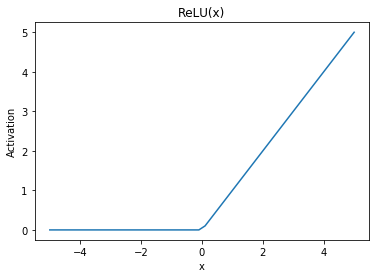

In [3]:
# this is just plotting code, you can skip it
import matplotlib.pyplot as plt
import numpy as np
x = np.linspace(-5, 5)
relu = np.maximum(0, x)
plt.plot(x, relu)
plt.title("ReLU(x)")
plt.ylabel("Activation")
_ = plt.xlabel("x")

Note that teeeeechnically $\text{ReLU}$ isn't differentiable at $x=0$. That's problematic for finding the partial derivatives of the network output with respect to the parameters in the $0$th layer. In practice, the derivative at $0$ is simply set to $0$ or $1$.

On the other hand, since the derivative of $\text{ReLU}$ is always $1$ or $0$, either...
* The derivative of error with respect to 0th layer parameters only get scaled by a factor of $1$ (avoids the vanishing/exploding gradient problem)
* The derivative of error with respect to 0th layer parameters get killed (dying ReLU problem)


In [4]:
# Now we're going to make a basic 2-layer Multilayer Perceptron custom Module.
class MLP(nn.Module):
    def __init__(self, num_features, hidden_dimension, num_outputs):
        super(MLP, self).__init__()
        # randomly initialize the W^0 and b^0 of the first linear transform
        self.layer0 = nn.Linear(num_features, hidden_dimension, bias=True)
        # choose which pointwise activation function you want
        self.f = nn.ReLU()  # ReLU(x_i) := max(0, x_i)
        self.layer1 = nn.Linear(hidden_dimension, num_outputs, bias=True)
        
    def forward(self, x):
        return self.layer1(self.f(self.layer0(x)))

In [5]:
# note we're not gonna bother normalizing X for this example since we have biases.
# this will make learning slower technically, but it's fine.
X = np.array(
    [[0, 0],
     [0, 1],
     [1, 0],
     [1, 1]
    ]
)
Y = np.array([0, 1, 1, 0])

In [6]:
X.shape

(4, 2)

In [7]:
Y.shape

(4,)

### Example 1 - Can Linear Approximate XOR?

First, we need to discuss how to do classification instead of regression.
This gets a little strange, so bear with me.
We're going to have the network output one number for a "True" and another number for a "False." That is, now we're outputting two numbers.
Then, we're going to normalize the output so that it sums to $1$ (i.e., it can be treated as a discrete pdf).

That normalization is performed with what's called the **softmax** function. We won't go into detail, but it's important to know that softmax is order-preserving. The $k$th highest element in the original network output is still the $k$th highest normalized element.

Our loss function becomes minimizing the "distance" between the output pdf and the true pdf (which is just a $1$ for the true class and $0$ for the others).
The loss function we want to minimize is called the **cross entropy loss**.
We won't go into details about how that works, but note that we're establishing all this formalism because it generalizes to when there's more classes than 2 (e.g., when we're interested about more than "True" and "False.").

In the PyTorch library, the cross entropy loss function actually wraps up softmax and the pdf distance function into one thing.

In [8]:
def train_xor(net, num_epochs=1000, lr=0.1):
    loss_fn = nn.CrossEntropyLoss()  # instantiate a cross entropy loss function - this guy is callable.
    # you can read about its parameters in the PyTorch documentation:
    # https://pytorch.org/docs/stable/nn.html#crossentropyloss

    optim = torch.optim.SGD(net.parameters(), lr=lr)  # this is Stochastic Gradient Descent

    for epoch in range(1, num_epochs + 1):
        optim.zero_grad()  # set gradient accumulators to 0
        # we'll batch up the whole dataset again since our dataset has 4 examples
        x_batch = torch.tensor(X, dtype=torch.float32)
        y_batch = torch.tensor(Y, dtype=torch.int64)

        y_hat_batch = net(x_batch)

        loss = loss_fn(y_hat_batch, y_batch)
        loss.backward()  # calculate the partials of "loss" with respect to each of the parameters
        optim.step()  # update the network's parameters with respect to each of the partials.

In [9]:
net1 = LinearNetwork(2, 2)  # instantiate a linear network from the 2 inputs to the two outputs (True and False)
print(net1)
train_xor(net1)

LinearNetwork(
  (layer0): Linear(in_features=2, out_features=2, bias=True)
)


In [10]:
# now let's run in inference mode, without any derivatives
with torch.no_grad():
    y_hat = net1(torch.tensor(X, dtype=torch.float32))
    predictions = y_hat.argmax(axis=1)

In [11]:
print("   Truth Table     ")
print()
print("x1 x2 | true | pred")
print("-------------------")
for (x, y), pred in zip(zip(X, Y), predictions):
    print(" {x1}  {x2} |    {true} |    {pred}".format(x1=x[0], x2=x[1], true=y, pred=pred))

   Truth Table     

x1 x2 | true | pred
-------------------
 0  0 |    0 |    0
 0  1 |    1 |    0
 1  0 |    1 |    0
 1  1 |    0 |    1


You can tell from the truth table that the linear model couldn't learn XOR.

This isn't a rigorous proof that it will never happen. You could try different weights, train longer, etc. Just giving an example.

### Example 2 - Can MLP Approximate XOR?

In [12]:
net2 = MLP(2, 1000, 2)  # instantiate an MLP with hidden size H=1000
print(net2)
train_xor(net2, num_epochs=1000)
# now let's run in inference mode, without any derivatives

with torch.no_grad():
    y_hat = net2(torch.tensor(X, dtype=torch.float32))
    predictions = y_hat.argmax(axis=1)
print("   Truth Table     ")
print()
print("x1 x2 | true | pred")
print("-------------------")
for (x, y), pred in zip(zip(X, Y), predictions):
    print(" {x1}  {x2} |    {true} |    {pred}".format(x1=x[0], x2=x[1], true=y, pred=pred))

MLP(
  (layer0): Linear(in_features=2, out_features=1000, bias=True)
  (f): ReLU()
  (layer1): Linear(in_features=1000, out_features=2, bias=True)
)
   Truth Table     

x1 x2 | true | pred
-------------------
 0  0 |    0 |    0
 0  1 |    1 |    1
 1  0 |    1 |    1
 1  1 |    0 |    0


The MLP on the other hand made short work of XOR.

## Apply the MLP to the Boston House Dataset

In [13]:
from sklearn.datasets import load_boston
dataset = load_boston()

data = dataset["data"]  # np.ndarray  shape: (examples, features)
target = dataset["target"]  # np.ndarray  shape: (examples,)

X = data  # X matrix is all the data
Y = target  # Y matrix is all the truth

In [14]:
import random
random.seed(4242)

data_index_array = list(range(X.shape[0]))
random.shuffle(data_index_array)
X_shuf = X[data_index_array]
Y_shuf = Y[data_index_array]

X_train = X[:400]  # normally you use about 80% for training and 20% for testing
Y_train = Y[:400]

X_test = X[400:]
Y_test = Y[400:]


def zero_mean_unit_variance(D):
    # D is a data matrix shaped (N_feats, ...)
    feat_means = np.mean(D, axis=0)  # (N_feats,)-shaped vector
    feat_vars = np.var(D, axis=0)  # (N_feats,)-shaped vector

    # variance of 0 means an uninformative/constant feature.
    # numerically, it's a problem b/c we can't divide by zero
    try:
        print("Check minimum variance is far from 0:", min(feat_vars))
    except Exception as e:
        print("Check minimum variance is far from 0:", feat_vars)


    D_normed = (D - feat_means) / np.sqrt(feat_vars)
    return D_normed, feat_means, feat_vars


X_norm_train, X_mean, X_var = zero_mean_unit_variance(X_train)
X_norm_test = (X_test - X_mean) / np.sqrt(X_var)
Y_norm_train, Y_mean, Y_var = zero_mean_unit_variance(Y_train)



Check minimum variance is far from 0: 0.012945226004437496
Check minimum variance is far from 0: 83.80700974999999


In [15]:
net = MLP(13, 100, 1)

lr = .0001  # learning rate eta  - since we're updating per batch, we'll want to lower this.
# that's because each update could be somehow more biased or overall less complete

def batchify(X, Y, n):
    for i in range(0, len(X), n):
        yield X[i:i + n], Y[i:i+n]

def total_error(net, X, Y, batch_size, y_var=None, y_mean=None):
    with torch.no_grad():
        error_T = 0
        for X_batch, Y_batch in batchify(X, Y, batch_size):
            X_batch = torch.tensor(X_batch, dtype=torch.float32)
            Y_batch = torch.tensor(Y_batch, dtype=torch.float32).unsqueeze(-1)
            Y_hat = net(X_batch)  # (num_samples, 1)
            if y_var is not None:
                Y_hat = Y_hat * np.sqrt(y_var) + y_mean
            error = (Y_hat - Y_batch)**2  # (num_samples, 1)
            error_t = error.sum()
            error_T += error_t
        return error_T

    
def train_boston(net, lr, batch_size=100, update_every=500, N_epochs=1000):
    batch_ctr = 0

    loss_fn = nn.MSELoss()  # instantiate a mean-squared-error loss function
    optim = torch.optim.Adam(net.parameters(), lr=lr)  # this is a modified stochastic gradient descent

    for epoch in range(1, N_epochs+1):
        # N = X_norm_train.shape[0]  # dataset size
        for x_batch, y_batch in batchify(X_norm_train, Y_norm_train, batch_size):
            net.train()
            optim.zero_grad()  # set gradient accumulators to 0

            # X_batch (num_samples,num_feats)
            y_batch = torch.tensor(y_batch, dtype=torch.float32).unsqueeze(-1)  # expand to (num_examples, 1)
            x_batch = torch.tensor(x_batch, dtype=torch.float32)

            y_hat_batch = net(x_batch)
            # print(y_hat_batch)
            loss = loss_fn(y_hat_batch, y_batch)
            loss.backward()  # calculate the partials of "loss" with respect to each of the parameters
            optim.step()  # update the network's parameters with respect to each of the partials.
            batch_ctr += 1

            if batch_ctr % update_every == 0:
                with torch.no_grad():
                    net.eval()
                    error = total_error(net, X_norm_train, Y_train, batch_size, y_var=Y_var, y_mean=Y_mean)
                    mean_error = error / X_train.shape[0]
                    print(f"Mean training error (real) after {batch_ctr}th update:", f"${mean_error:.2f}k")

                    error = total_error(net, X_norm_test, Y_test, batch_size, y_var=Y_var, y_mean=Y_mean)
                    mean_error = error / X_test.shape[0]
                    print(f"Mean testing error (real) after {batch_ctr}th update:", f"${mean_error:.2f}k")

                    print()
                
train_boston(net, lr)

Mean training error (real) after 500th update: $32.85k
Mean testing error (real) after 500th update: $19.89k

Mean training error (real) after 1000th update: $19.39k
Mean testing error (real) after 1000th update: $20.80k

Mean training error (real) after 1500th update: $14.61k
Mean testing error (real) after 1500th update: $22.70k

Mean training error (real) after 2000th update: $11.68k
Mean testing error (real) after 2000th update: $23.80k

Mean training error (real) after 2500th update: $9.61k
Mean testing error (real) after 2500th update: $24.93k

Mean training error (real) after 3000th update: $8.15k
Mean testing error (real) after 3000th update: $26.12k

Mean training error (real) after 3500th update: $7.04k
Mean testing error (real) after 3500th update: $27.77k

Mean training error (real) after 4000th update: $6.20k
Mean testing error (real) after 4000th update: $30.33k



In [16]:
samples = range(10)
y_hat_k = net(torch.tensor(X_norm_test[samples, :], dtype=torch.float32))
y_unnormed_hat_k = np.sqrt(Y_var) * (y_hat_k) + Y_mean

for k in samples:
    print(f"For house {k+1}, true price is ${Y[k]}K")
    print(f"We estimated ${y_unnormed_hat_k[k][0]}K")
    print()

For house 1, true price is $24.0K
We estimated $7.615077972412109K

For house 2, true price is $21.6K
We estimated $11.650252342224121K

For house 3, true price is $34.7K
We estimated $12.943846702575684K

For house 4, true price is $33.4K
We estimated $14.254494667053223K

For house 5, true price is $36.2K
We estimated $8.309564590454102K

For house 6, true price is $28.7K
We estimated $4.980039596557617K

For house 7, true price is $22.9K
We estimated $17.580551147460938K

For house 8, true price is $27.1K
We estimated $28.847810745239258K

For house 9, true price is $16.5K
We estimated $15.970133781433105K

For house 10, true price is $18.9K
We estimated $23.313526153564453K



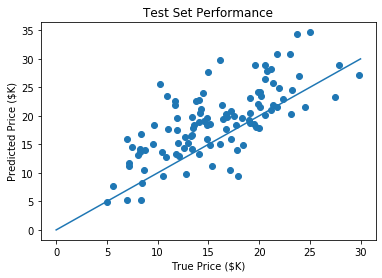

In [17]:
with torch.no_grad():
    y_hat_k = net(torch.tensor(X_norm_test, dtype=torch.float32)).numpy()
y_unnormed_hat_k = np.sqrt(Y_var) * (y_hat_k) + Y_mean

import matplotlib.pyplot as plt
plt.scatter(Y_test, y_unnormed_hat_k)
plt.plot(np.linspace(0, 30), np.linspace(0, 30))
plt.xlabel("True Price ($K)")
plt.ylabel("Predicted Price ($K)")
_ = plt.title("Test Set Performance")

## How Can We Improve Now? - Overfitting and Going Deeper

**Overfitting** happens when the neural network fails to **generalize** to the test set because it's "memorized" non-useful things in the training set in order to minimize the error.

We can avoid that with what's called **regularization techniques**. The most famous one is called dropout. Dropout randomly sets some percentage of the activations coming out of a layer to 0. To minimize error when using dropout, the network cannot rely on any single feature in making its determinations. Experimentally, this reduces overfitting.

In [18]:
class DeepMLP(nn.Module):
    def __init__(self, num_features, hidden_dimensions, num_outputs, dp_prob=0.5):
        super(DeepMLP, self).__init__()
        map_sizes = [num_features] + hidden_dimensions
        architecture = []
        for map_dim_in, map_dim_out in zip(map_sizes[:-1], map_sizes[1:]):
            architecture.extend([
                nn.Linear(map_dim_in, map_dim_out, bias=True),
                nn.ReLU(),
                nn.Dropout(dp_prob)
            ])
        architecture.append(nn.Linear(hidden_dimensions[-1], num_outputs, bias=True))
        self._net = nn.Sequential(*architecture)
        
    def forward(self, x):
        return self._net(x)

In [19]:
net = DeepMLP(13, [50, 50, 50], 1, dp_prob=0.3)
lr = 1e-4
train_boston(net, lr, batch_size=200, update_every=50, N_epochs=500)


Mean training error (real) after 50th update: $79.77k
Mean testing error (real) after 50th update: $91.86k

Mean training error (real) after 100th update: $71.95k
Mean testing error (real) after 100th update: $83.09k

Mean training error (real) after 150th update: $61.22k
Mean testing error (real) after 150th update: $67.73k

Mean training error (real) after 200th update: $48.95k
Mean testing error (real) after 200th update: $47.05k

Mean training error (real) after 250th update: $37.24k
Mean testing error (real) after 250th update: $28.11k

Mean training error (real) after 300th update: $28.99k
Mean testing error (real) after 300th update: $18.67k

Mean training error (real) after 350th update: $24.42k
Mean testing error (real) after 350th update: $15.71k

Mean training error (real) after 400th update: $21.88k
Mean testing error (real) after 400th update: $14.65k

Mean training error (real) after 450th update: $20.25k
Mean testing error (real) after 450th update: $14.38k

Mean trainin

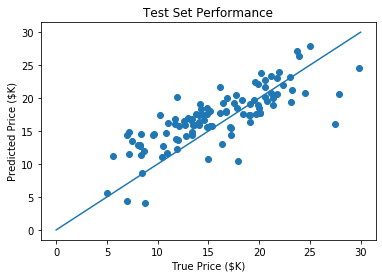

In [20]:
with torch.no_grad():
    net.eval()
    y_hat_k = net(torch.tensor(X_norm_test, dtype=torch.float32)).numpy()
y_unnormed_hat_k = np.sqrt(Y_var) * (y_hat_k) + Y_mean

plt.scatter(Y_test, y_unnormed_hat_k)
plt.plot(np.linspace(0, 30), np.linspace(0, 30))
plt.xlabel("True Price ($K)")
plt.ylabel("Predicted Price ($K)")
_ = plt.title("Test Set Performance")

## Takeaways

* Now you know how to formulate a multi-layer perceptron.
* You know that, to use gradient descent, you need the nonlinear activation function to be differentiable (almost everywhere).
    * The general term for using gradient descent in multiple-layer networks is called **backpropagation** (of errors) because the gradients of each layer end up being a factor in the gradients of the layer before.
* An MLP can theoretically approximate (almost) any function, but the theory doesn't guarantee we can find the weights.
* You saw the very popular nonlinear activation function $\text{ReLU} = \max(0, x)$ and know that it's popular because it doesn't scale the gradients (meaning, it doesn't scale the weight update) when it's active.
* You learned about overfitting and know that dropout is a technique for avoiding it.